In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix,csr_matrix,eye,bmat
from scipy.sparse.linalg import eigs,inv,gmres
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
%matplotlib inline

In [21]:
data = pd.read_csv('data/round_train.csv')
data1 = pd.read_csv('data/round_test.csv',header=None)
data1.columns = data.columns
data = pd.concat([data,data1])

In [22]:
data.shape

(231125, 12)

In [23]:
data.head()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694
2,2003,10,16,656,1761,"Mattiace, Len",1,13:00,75,24,24.0,0.656250
3,2003,10,16,656,1797,"Mediate, Rocco",1,12:10,72,T2,2.5,0.059028
4,2003,10,16,656,1920,"Parry, Craig",1,11:20,71,T25,26.5,0.725694


In [24]:
inds = {num:ind for ind,num in enumerate(pd.unique(data.Player_Number))}

In [25]:
data.insert(5,'Player_Index',[inds[num] for num in data.Player_Number])

In [58]:
rounds = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#'])

In [59]:
n_players = len(pd.unique(data.Player_Index))
n_rounds = len(rounds)
n_tournaments = len(data.groupby(['Tournament_Year','Permanent_Tournament_#']))

In [60]:
print n_players,n_rounds,n_tournaments

2461 2549 565


In [29]:
def alpha(A,a):
    w,v = eigs(A,k=1,which='LM')
    return a/w[0].real

In [30]:
(n_players*(n_rounds/60+1))**2 * 10 / 1.0e9

111.98507329

In [31]:
def load_sparse_csc(filename):
    loader = np.load(filename)
    return csc_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [52]:
def inflate(tournament_group,rounds_to_inflate,n_tournament_groups,BETA):
    mat = csc_matrix((n_players*n_tournament_groups,n_players),dtype=float)
    mat_1 = csc_matrix((n_players*n_tournament_groups,n_players),dtype=float)
    for j in rounds_to_inflate:
        mat += bmat([[load_sparse_csc('rounds/%d.npz' % j)*BETA**abs(tournament_group-k)] for k in range(1,n_tournament_groups+1)],format='csc')
        mat_1 += bmat([[(load_sparse_csc('rounds/%d.npz' % j)!=0).astype(float)*BETA**abs(tournament_group-k)] for k in range(1,n_tournament_groups+1)],format='csc')
    inflate.__dict__[tournament_group] = (mat,mat_1)
    out_mat = bmat([[inflate.__dict__[i][0][0:n_players*tournament_group] for i in range(1,tournament_group+1)]],format='csc')
    out_mat1 = bmat([[inflate.__dict__[i][1][0:n_players*tournament_group] for i in range(1,tournament_group+1)]],format='csc')
    return (out_mat,out_mat1)

In [53]:
def solve(mat,mat_1,a,x_guess=None,x_guess1=None):
    S = eye(mat.shape[0],format='csc')-alpha(mat,a)*mat
    w_a = gmres(S,mat.sum(1),x0=x_guess)[0]
    solve.w_a = w_a
    
    S = eye(mat_1.shape[0],format='csc')-alpha(mat_1,a)*mat_1 
    w_g = gmres(S,mat_1.sum(1),x0=x_guess1)[0]
    solve.w_g = w_g
    
    return ((w_a/w_g)[-n_players:],w_g[-n_players:])

In [62]:
ranks,reps = [],[]
BETA = .85
a = .8
bin_size = 4
n_tournament_groups = int(math.ceil(n_tournaments/float(bin_size)))
current_group = 0
tournament_groups=[set()]
tournaments = set()
rounds_to_inflate = []
for round_ind,df in enumerate(rounds):
    df = df[1]
    tournaments.add(','.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))
    tournament_group = len(tournaments)/bin_size
    rounds_to_inflate.append(round_ind)
    if tournament_group>current_group:
        A,G = inflate(tournament_group,rounds_to_inflate,n_tournament_groups,BETA)
        if current_group==0:
            res = solve(A,G,a)
            ranks.append(res[0])
            reps.append(res[1])
            print 'Tournament Group %d done' % tournament_group
            current_group = tournament_group
            tournament_groups.append(set())
            rounds_to_inflate = []
        else:
            w_a_approx = np.append(solve.w_a,solve.w_a[-n_players:])
            w_g_approx = np.append(solve.w_g,solve.w_g[-n_players:])
            res = solve(A,G,a,w_a_approx,w_g_approx)
            ranks.append(res[0])
            reps.append(res[1])
            print 'Tournament Group %d done' % tournament_group
            current_group = tournament_group
            tournament_groups.append(set())
            rounds_to_inflate = []
    tournament_groups[current_group].add(df.iloc[0]['Permanent_Tournament_#'])

Tournament Group 0 done
Tournament Group 1 done
Tournament Group 2 done
Tournament Group 3 done
Tournament Group 4 done
Tournament Group 5 done
Tournament Group 6 done
Tournament Group 7 done
Tournament Group 8 done
Tournament Group 9 done
Tournament Group 10 done
Tournament Group 11 done
Tournament Group 12 done
Tournament Group 13 done
Tournament Group 14 done
Tournament Group 15 done
Tournament Group 16 done
Tournament Group 17 done
Tournament Group 18 done
Tournament Group 19 done
Tournament Group 20 done
Tournament Group 21 done
Tournament Group 22 done
Tournament Group 23 done
Tournament Group 24 done
Tournament Group 25 done
Tournament Group 26 done
Tournament Group 27 done
Tournament Group 28 done
Tournament Group 29 done
Tournament Group 30 done


KeyboardInterrupt: 

In [63]:
for i in range(len(ranks)):
    df = pd.DataFrame({'rank':ranks[i],'reps':reps[i]}).dropna()
    print i,df['rank'].describe()

0 count    237.000000
mean       0.995557
std        0.027138
min        0.884476
25%        0.980301
50%        0.999290
75%        1.013299
max        1.059954
Name: rank, dtype: float64
1 count    326.000000
mean       0.991015
std        0.029849
min        0.866760
25%        0.975756
50%        0.995812
75%        1.011625
max        1.062674
Name: rank, dtype: float64
2 count    347.000000
mean       0.988227
std        0.030339
min        0.850534
25%        0.974987
50%        0.994303
75%        1.007393
max        1.061747
Name: rank, dtype: float64
3 count    376.000000
mean       0.985455
std        0.033028
min        0.849368
25%        0.971807
50%        0.993038
75%        1.008081
max        1.055649
Name: rank, dtype: float64
4 count    407.000000
mean       0.983878
std        0.032772
min        0.865925
25%        0.968371
50%        0.991790
75%        1.006153
max        1.051825
Name: rank, dtype: float64
5 count    462.000000
mean       0.982873
std        0.

In [67]:
def sph(x,a,b):
    if x<a:
        return min(1,b + 1.5*(x/a) - .5*(x/a)**3)
    else:
        return 1

In [73]:
a,b = .8,0
inds_to_name = {i:data[data.Player_Index==i].iloc[0].Player_Name for i in range(n_players)}
j=30
df = pd.DataFrame({'player_ind':range(n_players),
              'player_name':[inds_to_name[i] for i in range(n_players)],
              'rank':ranks[j],'reps':reps[j]}).sort_values('rank',ascending=False).dropna()
pct_reps = pd.Series(df.reps[df.reps!=0]).rank(pct=True)
df.insert(len(df.columns),'pct_reps',[0]*len(df))
df.ix[df.reps!=0,'pct_reps'] = pct_reps
df.insert(len(df.columns),'coeff',[sph(rep_pct,a,b) for rep_pct in df.pct_reps])
df.insert(len(df.columns),'new_rank',df['rank']*df.coeff)
df.sort_values('new_rank',ascending=False)

,player_ind,player_name,rank,reps,pct_reps,coeff,new_rank
277,277,"Woods, Tiger",1.044009,16187.754946,0.858879,1.000000,1.044009
13,13,"Singh, Vijay",1.041909,28178.314826,0.990654,1.000000,1.041909
162,162,"Mickelson, Phil",1.037766,16482.529559,0.860748,1.000000,1.037766
21,21,"Furyk, Jim",1.033074,20823.531194,0.914953,1.000000,1.033074
12,12,"Els, Ernie",1.032868,12046.641919,0.808411,1.000000,1.032868
27,27,"Goosen, Retief",1.031901,12882.721771,0.814953,1.000000,1.031901
60,60,"Perry, Kenny",1.028245,21222.183735,0.919626,1.000000,1.028245
293,293,"Clarke, Darren",1.027638,10959.395957,0.798131,0.999992,1.027629
331,331,"Scott, Adam",1.026299,14535.039181,0.837383,1.000000,1.026299
167,167,"Toms, David",1.026089,21222.913798,0.920561,1.000000,1.026089


In [ ]:
ranks,reps = [],[]
BETA = .95
a = .8
bin_size = 4
window_size = 30
n_tournament_groups = int(math.ceil(n_tournaments/float(bin_size)))
print n_tournament_groups
current_group = 0
tournament_set = set()
rounds_to_inflate = []
for round_ind,df in enumerate(rounds):
    df = df[1]
    tournament_set.add('-'.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))
    rounds_to_inflate.append(round_ind)
    tournament_group = len(tournament_set)/bin_size
    if tournament_group>current_group:
        A,G = inflate(tournament_group,rounds_to_inflate,n_tournament_groups,BETA,window_size)
        if current_group==0:
            rank,rep = solve(A,G,a)
            ranks.append(rank)
            reps.append(rep)
            print 'Tournament Group %d done' % tournament_group
            current_group = tournament_group
        else:
            w_a_approx = np.append(solve.w_a[0 if tournament_group<=window_size else n_players:],solve.w_a[-n_players:])
            w_g_approx = np.append(solve.w_g[0 if tournament_group<=window_size else n_players:],solve.w_g[-n_players:])
            rank,rep = solve(A,G,a,w_a_approx,w_g_approx)
            ranks.append(rank)
            reps.append(rep)
            print 'Tournament Group %d done' % tournament_group
            current_group = tournament_group
        rounds_to_inflate = []

In [ ]:
tournaments = [set()]
for round_ind,df in enumerate(rounds):
    df = df[1]
    round_group = round_ind/bin_size
    current_group = 0
    if round_group>current_group:
        tournaments.append(set())
        current_group = round_group
    tournaments[current_group].add('-'.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))
tournaments = tournaments[:current_group+1]

In [55]:
for i in range(1,len(tournaments)):
    tournaments[i] = tournaments[i]-tournaments[i-1]

In [56]:
tournaments

[{1, 2, 3, 4, 5, 6, 7, 16},
 {8, 9, 10, 11, 12, 14, 22},
 {18, 19, 20, 21, 23, 24, 26, 480},
 {25, 27, 28, 29, 34, 37, 100},
 {30, 32, 33, 35, 472, 474, 476, 505},
 {13, 41, 45, 47, 54, 473, 475},
 {2, 3, 4, 5, 6, 16, 60},
 {1, 7, 8, 9, 10, 11, 14, 22},
 {12, 18, 19, 20, 21, 25, 480},
 {23, 24, 26, 27, 28, 30, 37, 100},
 {29, 33, 34, 35, 472, 476, 505},
 {13, 32, 41, 45, 47, 54, 473, 474},
 {2, 3, 4, 6, 16, 60, 475},
 {1, 5, 7, 8, 9, 10, 11, 22},
 {12, 14, 18, 19, 20, 21, 25, 480},
 {23, 24, 26, 27, 28, 30, 37},
 {29, 33, 34, 35, 100, 472, 476, 505},
 {13, 32, 41, 45, 47, 473, 474},
 {2, 4, 6, 16, 54, 60, 475},
 {1, 3, 5, 7, 8, 9, 10, 11},
 {12, 14, 18, 19, 20, 22, 480},
 {21, 23, 24, 25, 26, 27, 28, 34},
 {29, 30, 33, 35, 37, 100, 472}]

In [ ]:
outcomes = []
for t_ind in range(1,len(tournaments)):
    years,t_ids = [int(i.split('-')[0]) for i in tournaments[t_ind]],[int(i.split('-')[1]) for i in tournaments[t_ind]]
    sub = data[data['Tournament_Year'].isin(years) & data['Permanent_Tournament_#'].isin(t_ids)]
    df1 = pd.DataFrame(sub.groupby(['Player_Index','Permanent_Tournament_#'],as_index=False)['Finishing_Pct'].mean())
    df1 = pd.DataFrame(df1.groupby('Player_Index')['Finishing_Pct'].mean())
    df2 = pd.DataFrame({'Player_Index':range(n_players),'Finishing_Pct':[df1.loc[i].values[0] if i in df1.index else 0 for i in range(n_players)]})
    outcomes += df2.Finishing_Pct.values.tolist()

In [207]:
ols = LinearRegression()
iso = IsotonicRegression(increasing=False)

In [ ]:
np.corrcoef(df.ratings,df.outcomes)

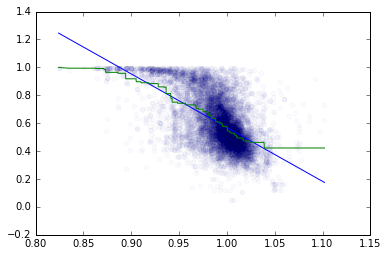

In [210]:
ratings,outcomes = [],[]
for t_ind in range(1,len(tournaments)):
    sub = data[data['Permanent_Tournament_#'].isin(tournaments[t_ind])]
    df1 = pd.DataFrame(sub.groupby('Player_Index')['Finishing_Pct'].mean())
    df2 = pd.DataFrame(ranks[t_ind-1],columns=['rating'])
    df = df1.merge(df2,left_index=True,right_index=True).dropna()
    ratings += df.rating.values.tolist()
    outcomes += df.Finishing_Pct.values.tolist()
ratings,outcomes = np.array(ratings),np.array(outcomes)
ols.fit(ratings[:,None],outcomes)
iso.fit(ratings,outcomes)
predictions_o = ols.predict(np.sort(ratings)[:,None])
predictions_i = iso.predict(np.sort(ratings))
plt.scatter(ratings,outcomes,alpha=.02)
plt.plot(np.sort(ratings),predictions_o)
plt.plot(np.sort(ratings),predictions_i)
plt.show()

In [50]:
print n_round_groups
print S.shape[0]**2

7
1768900


In [51]:
print len(S.nonzero()[1])/float(S.shape[0]**2)

0.15487704223


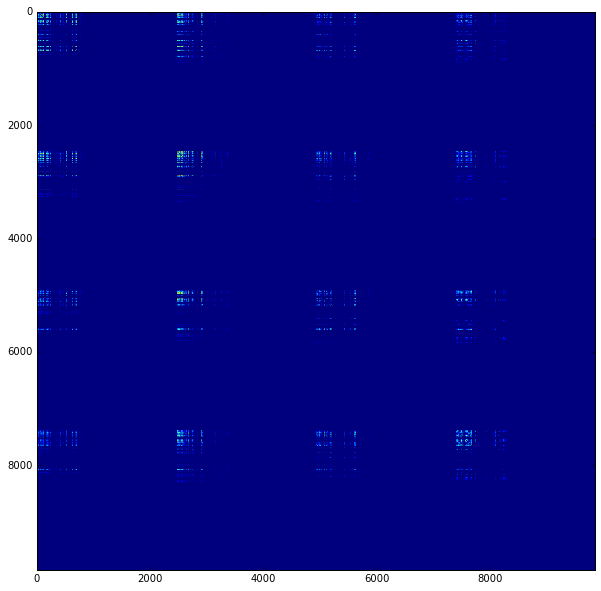

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(A[10*n_players:14*n_players,10*n_players:14*n_players].toarray());

In [42]:
inds_to_name = {i:data[data.Player_Index==i].iloc[0].Player_Name for i in range(n_players)}

In [64]:
pd.DataFrame({'player_ind':range(n_players),
              'player_name':[inds_to_name[i] for i in range(n_players)],
              'rank':ranks[20]}).sort_values('rank',ascending=False).dropna()

,player_ind,player_name,rank
13,13,"Singh, Vijay",1.044016
12,12,"Els, Ernie",1.043167
277,277,"Woods, Tiger",1.040388
793,793,"Levin, Spencer",1.038161
341,341,"Harrington, Padraig",1.035929
27,27,"Goosen, Retief",1.033581
162,162,"Mickelson, Phil",1.033434
848,848,"Remesy, Jean-Francois",1.029831
532,532,"Ruiz, Marco",1.029737
331,331,"Scott, Adam",1.029386


In [44]:
names_to_ind = {inds_to_name[key]:key for key in inds_to_name}

In [45]:
inds_to_plot = [names_to_ind['Woods, Tiger'],names_to_ind['Singh, Vijay']]

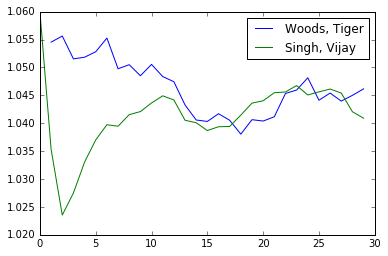

In [65]:
for j in inds_to_plot:
    plt.plot([ranks[i][j] for i in range(30)],label = inds_to_name[j]);
plt.legend();